# Make TFRecords from VOC XML & jpgs

THIS IS REDUNDANTE with UnderstandingObjectDetectionExample  
Use the other notebook for a full understanding

This was taken from ssd-dag repo

## Prerequitistes
### Input
1. you have jpeg images
2. you have annotations - XML format, VOC Pascal format standard

### Output
tfrecords_dir needs to have 3 subdirectories
/train
/val
/test

this code leverages the standards and templates as much as possible

## [OPTIONAL] Testing / Visualizing
This notebook also includes testing your tfrecord files by visualization.  Two methods:
- matplotlib
- (tensorflow/models)  object_detection.utils  (This is the preferred method)
Remember - you don't have a Linux desktop so, you can't use a GTK based solution like OpenCV for the display.


In [1]:
import os
import sys
import IPython.display as display
from PIL import Image

import matplotlib.pyplot as plt
# from matplotlib.patches import Rectangle
import matplotlib.patches as patches
# This is needed since we cloned tensorflow/models under code.
# - if you don't know what this means
#   Look at the notebook TrainModel_Step1_Local
#      in this notebook, you basically set up the project with includes cloning 
#      and compiling the tensorflow/models repo
#   we are using the utilities found in that repo

cwd = os.getcwd()
# this path is different in this project
models = os.path.abspath(os.path.join(cwd, '..', 'models/research/'))
slim = os.path.abspath(os.path.join(cwd, '..', 'models/research/slim'))
sys.path.append(models)
sys.path.append(slim)

import tensorflow as tf

from object_detection.utils import ops as utils_ops
from object_detection.utils.visualization_utils import STANDARD_COLORS
from object_detection.utils.visualization_utils import draw_bounding_box_on_image

# this is the standard feature dict
from example_utils import feature_obj_detect

In [2]:
from example_utils import voc_to_tfrecord_file

In [3]:
# this won't work with Tensorflow 2.0
# if you have TF 2.0 loaded, you can't set eager - it's forced on

print ('TensorFlow Version:', tf.__version__)
AUTOTUNE = tf.data.experimental.AUTOTUNE
tf.enable_eager_execution()

TensorFlow Version: 1.15.0


## Globals

This has been simplified from the ssd-dag project.   Kinda going back and forth between projects.  But there is no CODE and DATA -- everything is together

In [4]:
# Globals
# project directories
PROJECT = os.getcwd()

IMAGE_DIR = os.path.join(PROJECT, "jpeg_images")
ANNOTATION_DIR = os.path.join(PROJECT, "annotation")
LABEL_MAP_FILE = os.path.join(PROJECT, 'model', 'mscoco_label_map.pbtxt')
TFRECORD_DIR = os.path.join(PROJECT, 'tfrecord')
TRAINING_SPLIT_TUPLE =  (60,30,10)
INCLUDE_CLASSES = 'all'
EXCLUDE_TRUNCATED = False,
EXCLUDE_DIFFICULT = False

# Generating .tfrecord files from XML annotations & jpeg images

## Fix Labels

if you get an error like:  
!!! label map error: 20190625_polySauce_spicyBag_1561494037 smallSauce  skipped

This is telling you that the image_id:  20190625_polySauce_spicyBag_1561494037  
has a class label:  smallSauce  
which is not defined in the label map.  (don't be fooled!  'smallSauce' is the problem, not polySauce in the filename)

If there are a few - you could ignore it.   To fix the data locally:
1. review the label_map - $ cat code/cfa_prod_label_map.pbtxt;   youll see 7 == cfaSauce, 10 == polySauce, 
2. you need to change any 'smallSauce' to one of the labels in the label_map; we will choose cfaSauce 
3. add a sed command

In [ ]:
# you need to fix the labels
# it's in the other notebook:  UnderstaningObjectDetectionExample

# this is the label_map as a dict
#    {'smallHotDrink': 2, 'nuggBox': 5, 'sandBag': 6, 'smallFry': 8, 
#     'largeFry': 9, 'cfaSauce': 7, 'mediumColdDrink': 3, 'sandBox': 4, 
#   'hand': 1, 'spicyBag': 11, 'polySauce': 10}

# you might have to replace some names due to inconsistencies in labeling and the map

! sed -i 's/smHotDrink/smallHotDrink/g' data/annotations/*.xml
! sed -i 's/medColdDrink/mediumColdDrink/g' data/annotations/*.xml
! sed -i 's/smallSauce/cfaSauce/g' data/annotations/*.xml

## voc_to_tfrecord_file()
This program is in code/cfa_utils/example_utils.py    (Reminder - this isn't an example, it is tf.Example - ugh!) 

This progrm leverages as much of the standard TensorFlow code as possible.  That means:
- annotations are based on VOC PASCAL data standards.   There are hundreds of program examples that use this data which is an XML annotation format.
- the tf.Example(Feature) format is based on the format used in the MobileNet model.    I lifted it out of the /models code and placed it here where you can import it.  It is important that you have a consistent format through tfrecord generation, training, predictoin.   

I used a pattern where I imported the SSD Feature dictionary then copied it to a dict - then used that dict in the serialization.   You'll see that in the program.   The point is, the feature (dict) format is defined only once in one place.    (Look at the code.)  Odd side effect:   It seems that you must define every element of the dict.  If you don't, you'll get an error:  
--> 214             features = tf.train.Features(feature=feature)
    215 
    216             tf_example = tf.train.Example(features=features)

TypeError: MergeFrom() takes exactly one argument (3 given)

This program will tell you if it skips image/annotations due to bad labels.  (explained above).

### Result:

This is telling you that 3149 had a 'verified' (XML attribute) annotation and 22 were not verified.   That is normal.  WHen you label (using labelImg for example), you can skip a questionable training image by simply not verifying it.

This dict also shows label map, e.g. hand == class_id = 1

  verified: 3149   not: 22
{'hand': 1, 'smallHotDrink': 2, 'mediumColdDrink': 3, 'sandBox': 4, 'nuggBox': 5, 'sandBag': 6, 'cfaSauce': 7, 'smallFry': 8, 'largeFry': 9, 'polySauce': 10, 'spicyBag': 11}

This is telling you 1889 images were written to the train.tfrecord file.  (not sharded)  
169 objects were class_id = 6 (sandBag)  
568 objects were class_id = 4 (nuggBox)  
These totals will sum >= 1889 because there may be multiple objects per image.

 -- images 1889  writing to: /home/ec2-user/SageMaker/ssd-dag/tmp/train/train.tfrecord
     image count: 1889   class_count: {6: 169, 9: 286, 5: 563, 11: 178, 2: 441, 4: 568, 8: 291, 1: 927, 3: 572, 10: 412, 7: 157}
     
### file output
NOTE - these files were written (depending on your GLOBAL value) to /tmp.    Write to tmp, then promote to S3 if you want to use these.    Look at the training program (notebook) to see where it pulls tfrecords (hint: it won't be /tmp)

In [5]:
voc_to_tfrecord_file(IMAGE_DIR,
                    ANNOTATION_DIR,
                    LABEL_MAP_FILE,
                    TFRECORD_DIR,
                    TRAINING_SPLIT_TUPLE)


  verified: 51   not: 1
{'person': 1, 'bicycle': 2, 'car': 3, 'motorcycle': 4, 'airplane': 5, 'bus': 6, 'train': 7, 'truck': 8, 'boat': 9, 'traffic light': 10, 'fire hydrant': 11, 'stop sign': 13, 'parking meter': 14, 'bench': 15, 'bird': 16, 'cat': 17, 'dog': 18, 'horse': 19, 'sheep': 20, 'cow': 21, 'elephant': 22, 'bear': 23, 'zebra': 24, 'giraffe': 25, 'backpack': 27, 'umbrella': 28, 'handbag': 31, 'tie': 32, 'suitcase': 33, 'frisbee': 34, 'skis': 35, 'snowboard': 36, 'sports ball': 37, 'kite': 38, 'baseball bat': 39, 'baseball glove': 40, 'skateboard': 41, 'surfboard': 42, 'tennis racket': 43, 'bottle': 44, 'wine glass': 46, 'cup': 47, 'fork': 48, 'knife': 49, 'spoon': 50, 'bowl': 51, 'banana': 52, 'apple': 53, 'sandwich': 54, 'orange': 55, 'broccoli': 56, 'carrot': 57, 'hot dog': 58, 'pizza': 59, 'donut': 60, 'cake': 61, 'chair': 62, 'couch': 63, 'potted plant': 64, 'bed': 65, 'dining table': 67, 'toilet': 70, 'tv': 72, 'laptop': 73, 'mouse': 74, 'remote': 75, 'keyboard': 76, 'cel

1

## [Optional] Test your TFRecords 
Select your source of tfrecords
data/tfrecords is the source used in training.  
tmp is the source you just created

In [6]:
# TFRECORD_DIR = '/home/ec2-user/SageMaker/ssd-dag/data/tfrecords'
# TFRECORD_DIR = '/home/ec2-user/SageMaker/ssd-dag/tmp'
print (TFRECORD_DIR)

/media/home/jay/projects/camera-api/tfrecord


In [7]:
# This will read a list of files
# let's combine train, val & test


tfrecord_file_list_input = [os.path.join(TFRECORD_DIR, 'train/train.tfrecord'),
                            os.path.join(TFRECORD_DIR, 'val/val.tfrecord'),
                            os.path.join(TFRECORD_DIR, 'test/test.tfrecord')]
print ("reading:", tfrecord_file_list_input)
raw_dataset = tf.data.TFRecordDataset(tfrecord_file_list_input)
raw_dataset.cache()  # cache to memory
raw_dataset.shuffle(buffer_size=5000)
print (type(raw_dataset))

reading: ['/media/home/jay/projects/camera-api/tfrecord/train/train.tfrecord', '/media/home/jay/projects/camera-api/tfrecord/val/val.tfrecord', '/media/home/jay/projects/camera-api/tfrecord/test/test.tfrecord']
<class 'tensorflow.python.data.ops.readers.TFRecordDatasetV1'>


### Reading the TFRecords
- The file is read into a dataset (TFRecordDatasetV1 to be exact)
- Iterating through the records:
  - each record is an EagerTensor (you must have Eager Execution enabled)
  - This tensor has a serialized tf.Example
      - byte string
      - get the value (byte string) with .numpy()
  - parse the serialized byte string into an Example
      - tf.Example is made of Features
          - feature[key] == each part of the observation or data point
          
So, make sure this is correct.
      

In [8]:
# this iteration will show you:
# - each record
# - each tf.Example
# BUT - it is not a parsed tf.Example,  it looks readable, but it's not yet consumable
#   look at the next code block for that

# VERIFY your mapping using this loop

for raw_record in raw_dataset.take(1):
    print("raw record type:", type(raw_record))  # serialized Example
    print("Tensor.dtype:", raw_record.dtype)
    print("       value:", raw_record.numpy()[:50], '\n')
    
    example = tf.train.Example()
    example.ParseFromString(raw_record.numpy())  # Parse will de-serialize it
    # review this to verify the features were mapped correctly
    print(type(example), '\n', example)


raw record type: <class 'tensorflow.python.framework.ops.EagerTensor'>
Tensor.dtype: <dtype: 'string'>
       value: b'\n\x9b\xf5\x02\n\x15\n\x0bimage/width\x12\x06\x1a\x04\n\x02\x80\x05\n\x17\n\x0cimage/format\x12\x07\n\x05\n\x03j' 

<class 'tensorflow.core.example.example_pb2.Example'> 
 features {
  feature {
    key: "image/class/label"
    value {
      int64_list {
        value: 1
      }
    }
  }
  feature {
    key: "image/class/text"
    value {
      bytes_list {
        value: "cfa_prod"
      }
    }
  }
  feature {
    key: "image/encoded"
    value {
      bytes_list {
        value: "\377\330\377\340\000\020JFIF\000\001\001\000\000\001\000\001\000\000\377\333\000C\000\002\001\001\001\001\001\002\001\001\001\002\002\002\002\002\004\003\002\002\002\002\005\004\004\003\004\006\005\006\006\006\005\006\006\006\007\t\010\006\007\t\007\006\006\010\013\010\t\n\n\n\n\n\006\010\013\014\013\n\014\t\n\n\n\377\333\000C\001\002\002\002\002\002\002\005\003\003\005\n\007\006\007\n\n\n

### Parsing each tf.Example record

This parses the serialized tf.Example into the feature (dict).   This is where we use that common feature definition to make sure the format is good.   feature_obj_detect is imported from:
code.cfa_utils.example_utils.py  

This isn't something I defined - I lifted it out of the code in tensorflow/models

In [9]:
print ("feature_obj_detect:", type(feature_obj_detect), '\n', feature_obj_detect)
def _parse_function(example_proto):
    # Parse the input using the standard dictionary
    feature = tf.io.parse_single_example(example_proto, feature_obj_detect)
    return feature

feature_obj_detect: <class 'dict'> 
 {'image/encoded': FixedLenFeature(shape=(), dtype=tf.string, default_value=''), 'image/format': FixedLenFeature(shape=(), dtype=tf.string, default_value='jpeg'), 'image/filename': FixedLenFeature(shape=(), dtype=tf.string, default_value=''), 'image/key/sha256': FixedLenFeature(shape=(), dtype=tf.string, default_value=''), 'image/source_id': FixedLenFeature(shape=(), dtype=tf.string, default_value=''), 'image/height': FixedLenFeature(shape=(), dtype=tf.int64, default_value=1), 'image/width': FixedLenFeature(shape=(), dtype=tf.int64, default_value=1), 'image/class/text': VarLenFeature(dtype=tf.string), 'image/class/label': VarLenFeature(dtype=tf.int64), 'image/object/bbox/xmin': VarLenFeature(dtype=tf.float32), 'image/object/bbox/xmax': VarLenFeature(dtype=tf.float32), 'image/object/bbox/ymin': VarLenFeature(dtype=tf.float32), 'image/object/bbox/ymax': VarLenFeature(dtype=tf.float32), 'image/object/class/label': VarLenFeature(dtype=tf.int64), 'image/o

In [10]:
parsed_dataset = raw_dataset.map(_parse_function)
print (parsed_dataset)

<DatasetV1Adapter shapes: {image/class/label: (?,), image/class/text: (?,), image/object/area: (?,), image/object/bbox/xmax: (?,), image/object/bbox/xmin: (?,), image/object/bbox/ymax: (?,), image/object/bbox/ymin: (?,), image/object/class/label: (?,), image/object/class/text: (?,), image/object/difficult: (?,), image/object/group_of: (?,), image/object/is_crowd: (?,), image/object/weight: (?,), image/encoded: (), image/filename: (), image/format: (), image/height: (), image/key/sha256: (), image/source_id: (), image/width: ()}, types: {image/class/label: tf.int64, image/class/text: tf.string, image/object/area: tf.float32, image/object/bbox/xmax: tf.float32, image/object/bbox/xmin: tf.float32, image/object/bbox/ymax: tf.float32, image/object/bbox/ymin: tf.float32, image/object/class/label: tf.int64, image/object/class/text: tf.string, image/object/difficult: tf.int64, image/object/group_of: tf.int64, image/object/is_crowd: tf.int64, image/object/weight: tf.float32, image/encoded: tf.s

## tensorflow/models/object_detection/visualization_util.py

THIS is the way to display - much easier!

record type: <class 'dict'>
image/encoded type: <class 'tensorflow.python.framework.ops.EagerTensor'>
image/encoded EagerTensor.numpy(): <class 'bytes'>
is jpeg: tf.Tensor(True, shape=(), dtype=bool)
tf.image.decode_jpeg(image_tensor): (480, 640, 3)
<class 'numpy.ndarray'> [b'person' b'potted plant']
xmins: <class 'numpy.ndarray'> [0.4109375 0.1953125]


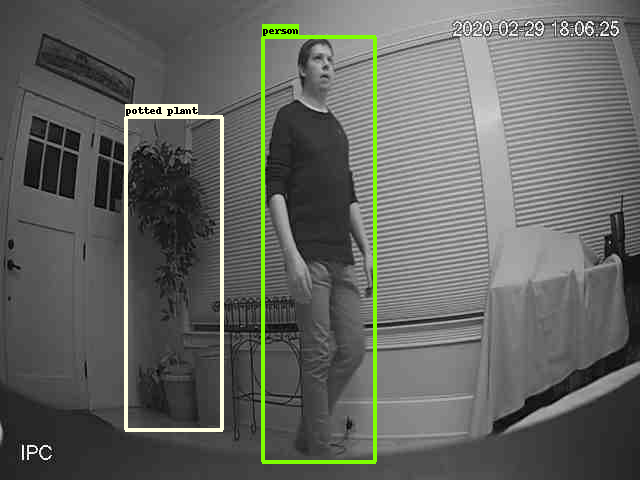


record type: <class 'dict'>
image/encoded type: <class 'tensorflow.python.framework.ops.EagerTensor'>
image/encoded EagerTensor.numpy(): <class 'bytes'>
is jpeg: tf.Tensor(True, shape=(), dtype=bool)
tf.image.decode_jpeg(image_tensor): (480, 640, 3)
<class 'numpy.ndarray'> [b'person' b'backpack' b'potted plant']
xmins: <class 'numpy.ndarray'> [0.228125 0.278125 0.2     ]


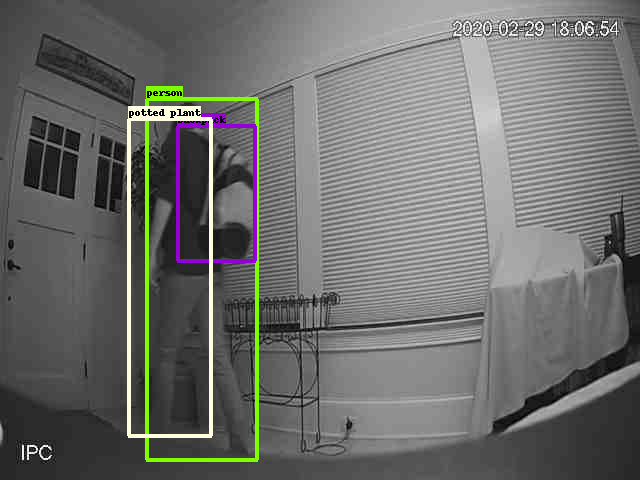


record type: <class 'dict'>
image/encoded type: <class 'tensorflow.python.framework.ops.EagerTensor'>
image/encoded EagerTensor.numpy(): <class 'bytes'>
is jpeg: tf.Tensor(True, shape=(), dtype=bool)
tf.image.decode_jpeg(image_tensor): (480, 640, 3)
<class 'numpy.ndarray'> [b'person' b'backpack' b'book' b'potted plant']
xmins: <class 'numpy.ndarray'> [0.3390625 0.48125   0.425     0.1796875]


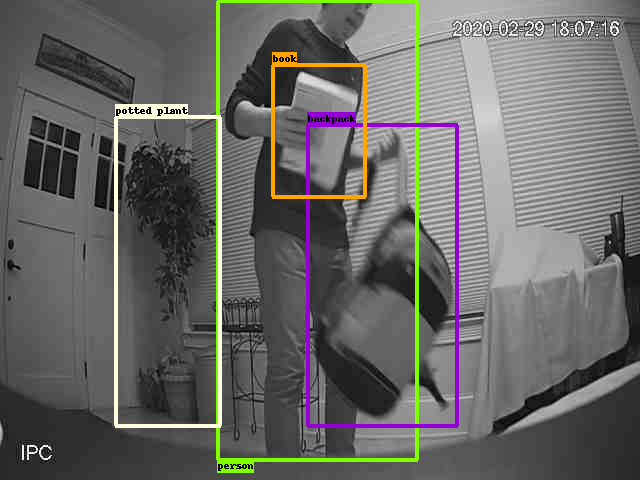


record type: <class 'dict'>
image/encoded type: <class 'tensorflow.python.framework.ops.EagerTensor'>
image/encoded EagerTensor.numpy(): <class 'bytes'>
is jpeg: tf.Tensor(True, shape=(), dtype=bool)
tf.image.decode_jpeg(image_tensor): (480, 640, 3)
<class 'numpy.ndarray'> [b'person' b'potted plant']
xmins: <class 'numpy.ndarray'> [0.3734375 0.1828125]


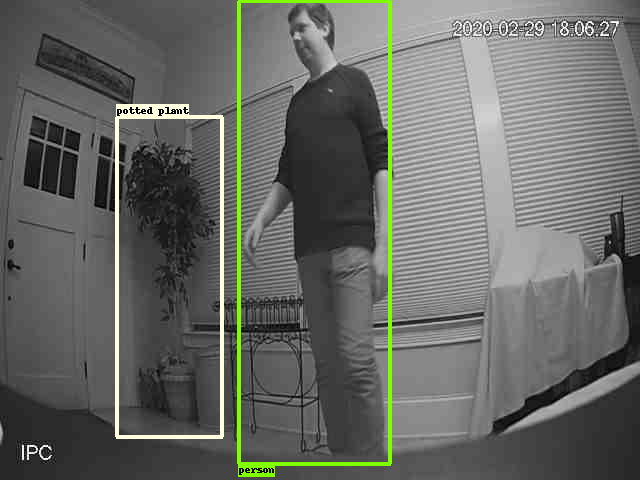


record type: <class 'dict'>
image/encoded type: <class 'tensorflow.python.framework.ops.EagerTensor'>
image/encoded EagerTensor.numpy(): <class 'bytes'>
is jpeg: tf.Tensor(True, shape=(), dtype=bool)
tf.image.decode_jpeg(image_tensor): (480, 640, 3)
<class 'numpy.ndarray'> [b'person' b'book' b'potted plant']
xmins: <class 'numpy.ndarray'> [0.440625  0.5984375 0.1828125]


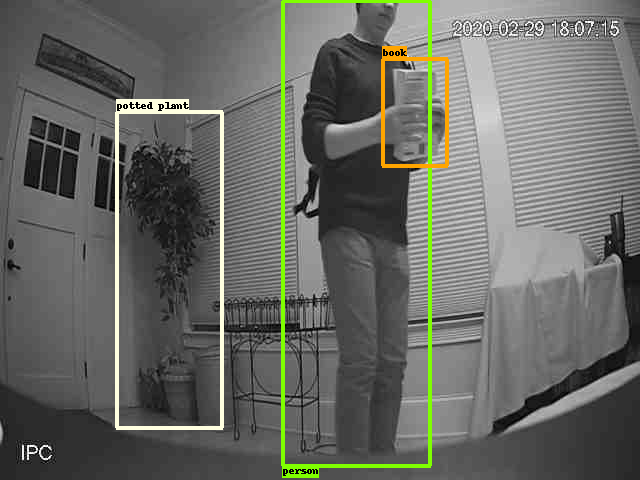


record type: <class 'dict'>
image/encoded type: <class 'tensorflow.python.framework.ops.EagerTensor'>
image/encoded EagerTensor.numpy(): <class 'bytes'>
is jpeg: tf.Tensor(True, shape=(), dtype=bool)
tf.image.decode_jpeg(image_tensor): (480, 640, 3)
<class 'numpy.ndarray'> [b'potted plant']
xmins: <class 'numpy.ndarray'> [0.1828125]


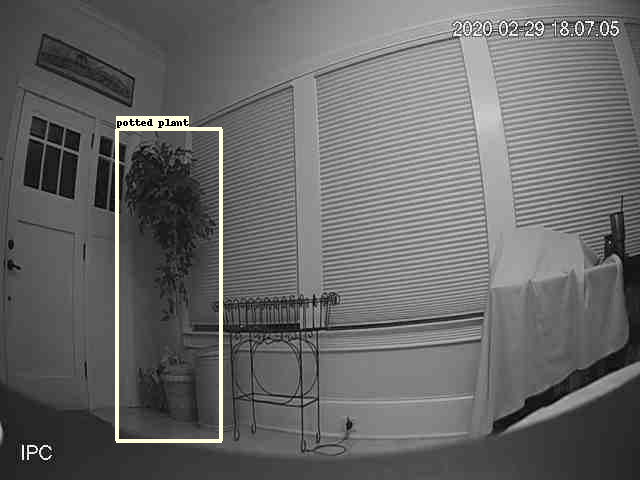


record type: <class 'dict'>
image/encoded type: <class 'tensorflow.python.framework.ops.EagerTensor'>
image/encoded EagerTensor.numpy(): <class 'bytes'>
is jpeg: tf.Tensor(True, shape=(), dtype=bool)
tf.image.decode_jpeg(image_tensor): (480, 640, 3)
<class 'numpy.ndarray'> [b'person']
xmins: <class 'numpy.ndarray'> [0.1703125]


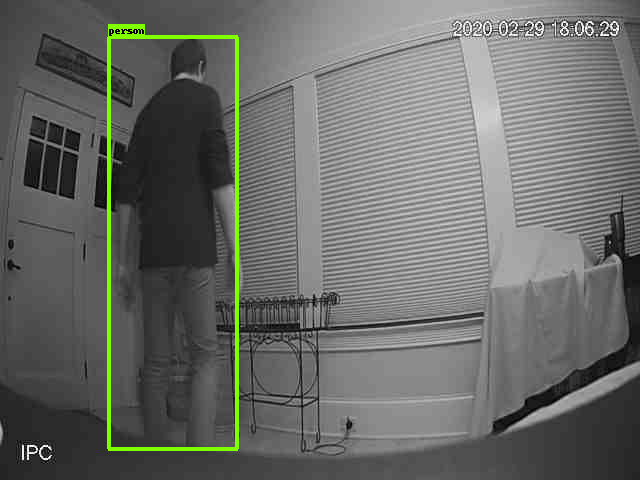


record type: <class 'dict'>
image/encoded type: <class 'tensorflow.python.framework.ops.EagerTensor'>
image/encoded EagerTensor.numpy(): <class 'bytes'>
is jpeg: tf.Tensor(True, shape=(), dtype=bool)
tf.image.decode_jpeg(image_tensor): (480, 640, 3)
<class 'numpy.ndarray'> [b'person' b'potted plant']
xmins: <class 'numpy.ndarray'> [0.05      0.1859375]


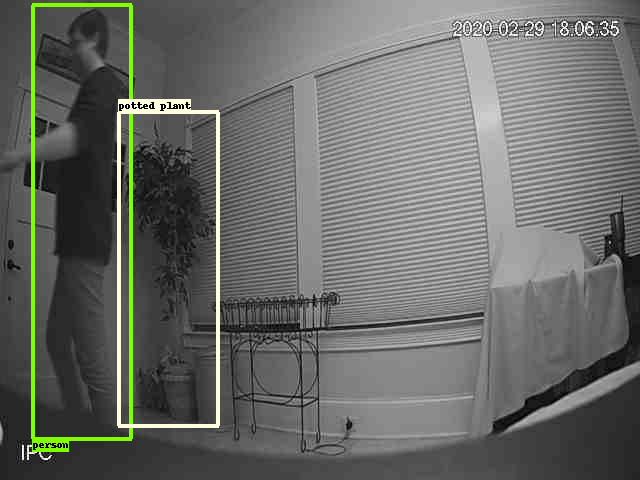


record type: <class 'dict'>
image/encoded type: <class 'tensorflow.python.framework.ops.EagerTensor'>
image/encoded EagerTensor.numpy(): <class 'bytes'>
is jpeg: tf.Tensor(True, shape=(), dtype=bool)
tf.image.decode_jpeg(image_tensor): (480, 640, 3)
<class 'numpy.ndarray'> [b'person' b'backpack' b'book' b'potted plant']
xmins: <class 'numpy.ndarray'> [0.328125  0.51875   0.3859375 0.1828125]


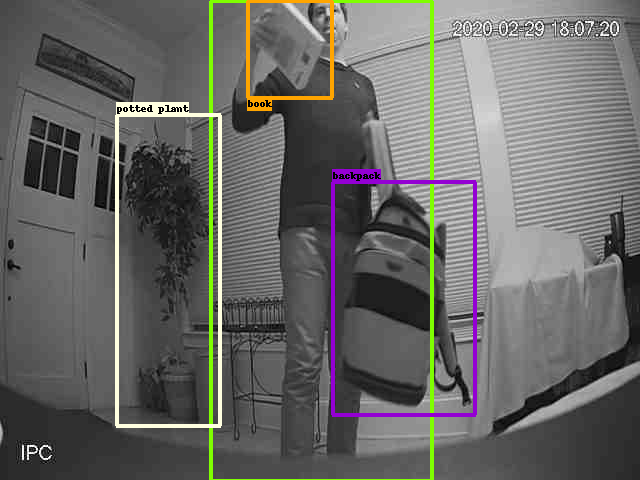


record type: <class 'dict'>
image/encoded type: <class 'tensorflow.python.framework.ops.EagerTensor'>
image/encoded EagerTensor.numpy(): <class 'bytes'>
is jpeg: tf.Tensor(True, shape=(), dtype=bool)
tf.image.decode_jpeg(image_tensor): (480, 640, 3)
<class 'numpy.ndarray'> [b'person' b'backpack' b'potted plant']
xmins: <class 'numpy.ndarray'> [0.5109375 0.5625    0.1796875]


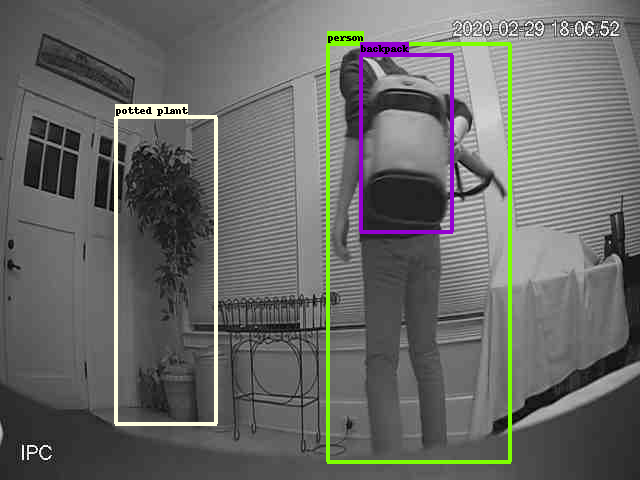

In [11]:
# tensorflow/models/object_detection

for n,i in enumerate(parsed_dataset.take(10)):
    print ("record type:", type(i))
    print ("image/encoded type:", type(i['image/encoded']))
    image_tensor = i['image/encoded'].numpy()  # bytes
    print ("image/encoded EagerTensor.numpy():", type(image_tensor))
    print("is jpeg:", tf.io.is_jpeg(image_tensor))
    
    jpeg_decoded_tensor = tf.image.decode_jpeg(image_tensor)
    jpeg_numpy = jpeg_decoded_tensor.numpy()
    print ("tf.image.decode_jpeg(image_tensor):", jpeg_numpy.shape)
    
    # get height/width
    height = i['image/height'].numpy()
    width =  i['image/width'].numpy()
    
    # get object classes
    obj_class_names = i['image/object/class/text'].values.numpy()
    obj_class_ids = i['image/object/class/label'].values.numpy()
    obj_count = len(obj_class_ids)
    
    print (type(obj_class_names), obj_class_names)
    # get the bounding box coordinates
    xmins = i['image/object/bbox/xmin'].values.numpy()
    xmaxs = i['image/object/bbox/xmax'].values.numpy()
    ymins = i['image/object/bbox/ymin'].values.numpy()
    ymaxs = i['image/object/bbox/ymax'].values.numpy()
    print ('xmins:', type(xmins), xmins)
    xmins_pixel = xmins * width
    xmaxs_pixel = xmaxs * width
    ymins_pixel = ymins * height
    ymaxs_pixel = ymaxs * height
   
    pil_image = Image.fromarray(jpeg_numpy)    
    for idx in range(obj_count):
        draw_bounding_box_on_image(pil_image,ymins[idx],xmins[idx], ymaxs[idx], xmaxs[idx],
                                  color=STANDARD_COLORS[obj_class_ids[idx]], 
                                  thickness=4, display_str_list=[obj_class_names[idx]],
                                  use_normalized_coordinates=True)
        
    display.display(pil_image)
    print ()